In [1]:
from bs4 import BeautifulSoup
import re
import requests
import pandas as pd
import yfinance as yf

In [2]:
def sector_classification(url):   
    response = requests.get(url, headers={'User-Agent':'test'})
    soup = BeautifulSoup(response.content, "html.parser")
    soup_list = soup.find(id = "MainContent_tStock")
    sector_stock = [stock.getText() for stock in soup_list.find_all('a')]
    
    stock_list = []
    for stock in sector_stock:
        refined = re.findall(r'[0-9A-Z&]+', stock)
        stock_list.append(refined)     
    return sum(stock_list,[]) 


def code_or_name(stock_list, condition):
    new_stock = []
    if condition == 'code':
        for stock in stock_list:
            if re.findall(r'[0-9]{4}', stock):
                new_stock.append(stock)                
    elif condition == 'name':
        for stock in stock_list:
            if re.findall(r'[A-Z&]+', stock):
                new_stock.append(stock)
    else:
        pass
    return new_stock



def get_market_cap(stock_code): 
    url = "https://www.malaysiastock.biz/Corporate-Infomation.aspx?securityCode={}".format(stock_code)
    response = requests.get(url, headers={'User-Agent':'test'})
    soup = BeautifulSoup(response.content, "html.parser")
    table = (soup.find_all("label", attrs={"id":'MainContent_lbFinancialInfo_Capital'}))
    return table[0].getText()


def get_stock_price(ticker):   
    data = yf.download(ticker, period = "6mo", group_by="Ticker", interval='1mo')
    data.dropna(inplace=True)       
    return data

def stock_return_monthly(data):
    try: 
        monthly_return = round((data.iloc[-1,3]-data.iloc[-3,0])/data.iloc[-3,0],4)  
        
    except:
        monthly_return = round((data.iloc[-1,3]-data.iloc[-2,0])/data.iloc[-2,0],4) 
   
    return monthly_return*100
# def stock_return(data, condition):
#     if condition == 6:
#         monthly_return = round((data.iloc[-1,3]-data.iloc[0,0])/data.iloc[0,0],4)  
#     elif condition == 3:
#         monthly_return = round((data.iloc[-1,3]-data.iloc[3,0])/data.iloc[3,0],4)
#     elif condition == 1:
#         monthly_return = round((data.iloc[-1,3]-data.iloc[-3,0])/data.iloc[-3,0],4)
#     else:
#         monthly_return = 0
#     return monthly_return*100

In [3]:
construction_sector = sector_classification('https://www.malaysiastock.biz/Listed-Companies.aspx?type=S&s1=3')
consumer_sector = sector_classification('https://www.malaysiastock.biz/Listed-Companies.aspx?type=S&s1=4')
energy_sector = sector_classification('https://www.malaysiastock.biz/Listed-Companies.aspx?type=S&s1=5')
finance_sector = sector_classification('https://www.malaysiastock.biz/Listed-Companies.aspx?type=S&s1=9')
healthcare_sector = sector_classification('https://www.malaysiastock.biz/Listed-Companies.aspx?type=S&s1=10')
industrial_sector = sector_classification('https://www.malaysiastock.biz/Listed-Companies.aspx?type=S&s1=11')
plantation_sector = sector_classification('https://www.malaysiastock.biz/Listed-Companies.aspx?type=S&s1=12')
property_sector = sector_classification('https://www.malaysiastock.biz/Listed-Companies.aspx?type=S&s1=13')
reits_sector = sector_classification('https://www.malaysiastock.biz/Listed-Companies.aspx?type=S&s1=14')
technology_sector = sector_classification('https://www.malaysiastock.biz/Listed-Companies.aspx?type=S&s1=17')
telco_sector = sector_classification('https://www.malaysiastock.biz/Listed-Companies.aspx?type=S&s1=18')
transport_sector = sector_classification('https://www.malaysiastock.biz/Listed-Companies.aspx?type=S&s1=19')
utilities_sector = sector_classification('https://www.malaysiastock.biz/Listed-Companies.aspx?type=S&s1=20')

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


In [4]:
def feature_1(chosen_sector, sector_name):
    chosen_stock_code = code_or_name(chosen_sector, 'code')
    chosen_stock_name = code_or_name(chosen_sector, 'name')
    if "5235SS" in chosen_stock_name:
        chosen_stock_name.remove("5235SS")
    
    market_cap = []
    for stock_code in chosen_stock_code:
        each_stock_market_cap = get_market_cap(stock_code)
        each_stock_market_cap_formatted = re.sub(r'[: ]', '', each_stock_market_cap)
        market_cap.append(each_stock_market_cap_formatted)
    
    market_cap_formatted = []
    for i in market_cap:
        if re.findall(r'm',i):
            a = re.sub(r'm', '', i)
            market_cap_formatted.append(float(a))
        elif re.findall(r'b',i):
            b = re.sub(r'b', '', i)
            market_cap_formatted.append(float(b)*1000)
        
    monthly_return = []

    for ticker in chosen_stock_code:
        try: 
            data = get_stock_price(ticker+'.KL')
            monthly_return.append(stock_return_monthly(data))       
        except:
            monthly_return.append(0)
    
    data = {}
    data['Stock_name']=chosen_stock_name
    data['Stock_code']=chosen_stock_code
    data['Market_cap_in_million']= market_cap_formatted    
    data['One_month_return'] = monthly_return
    
    df = pd.DataFrame(data)
    df_new = df.sort_values(['Market_cap_in_million'],ascending=False).reset_index()
    top_twenty = df_new.iloc[:20, :]
    print(f'\n {sector_name} has an average of {round(df["One_month_return"].mean(),2)}% return in the past month. \n')
    return top_twenty

In [5]:
feature_1(construction_sector, 'Construction_sector')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(




 Construction_sector has an average of -5.63% return in the past month. 



,index,Stock_name,Stock_code,Market_cap_in_million,One_month_return
0,15,GAMUDA,5398,8122.00,14.80
1,22,IJM,3336,5432.00,4.93
2,47,SUNCON,5263,2017.00,7.59
3,26,KERJAYA,7161,1391.00,0.90
4,12,EKOVEST,8877,1078.00,-3.61
5,2,AME,5293,1044.00,-13.30
6,60,WIDAD,0162,935.85,-4.23
7,58,WCEHB,3565,866.44,-1.69
8,21,HSL,6238,786.61,0.75
9,59,WCT,9679,694.89,-3.92


In [6]:
feature_1(energy_sector, 'Energy_sector')

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(




1 Failed download:
- 1201.KL: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

 Energy_sector has an average of -10.33% return in the past month. 



C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


,index,Stock_name,Stock_code,Market_cap_in_million,One_month_return
0,8,DIALOG,7277,15357.00,6.25
1,33,YINSON,7293,5299.00,-12.55
2,11,HIBISCS,5199,2369.00,16.83
3,1,ARMADA,5210,2363.00,-27.27
4,24,SERBADK,5279,1305.00,0.00
5,18,PETRONM,3042,1220.00,4.63
6,10,HENGYUAN,4324,1170.00,-3.94
7,6,DAYANG,5141,960.95,-8.79
8,4,COASTAL,5071,955.39,0.00
9,31,VELESTO,5243,903.72,-21.43


In [7]:
feature_1(consumer_sector, 'Consumer_sector')

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 03015.KL: No data found, symbol may be delisted


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(




1 Failed download:
- 03009.KL: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

 Consumer_sector has an average of -2.66% return in the past month. 



,index,Stock_name,Stock_code,Market_cap_in_million,One_month_return
0,120,NESTLE,4707,31939.0,3.18
1,149,PPB,4065,23900.0,5.79
2,115,MRDIY,5296,22618.0,1.41
3,143,PETDAG,5681,20564.0,6.70
4,67,GENTING,3182,17562.0,3.66
5,66,GENM,4715,17517.0,8.06
6,171,SIME,4197,15459.0,5.58
7,155,QL,7084,11487.0,-5.03
8,56,F&N,3689,7930.0,-12.47
9,73,HEIM,3255,6423.0,3.91


In [8]:
feature_1(finance_sector, 'Finance_sector')

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

 Finance_sector has an average of 0.68% return in the past month. 



C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


,index,Stock_name,Stock_code,Market_cap_in_million,One_month_return
0,22,MAYBANK,1155,105838.00,7.74
1,28,PBBANK,1295,85407.00,8.65
2,8,CIMB,1023,51618.00,-2.88
3,12,HLBANK,5819,44005.00,4.64
4,30,RHBBANK,1066,24070.00,4.50
5,14,HLFG,1082,22537.00,7.91
6,4,AMBANK,1015,11069.00,2.45
7,6,BIMB,5258,6315.00,-6.98
8,19,LPI,8621,5561.00,-4.25
9,0,ABMB,2488,5233.00,2.42


In [9]:
feature_1(healthcare_sector, 'Healthcare_sector')

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

 Healthcare_sector has an average of -6.34% return in the past month. 



C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


,index,Stock_name,Stock_code,Market_cap_in_million,One_month_return
0,5,IHH,5225,56398.00,-0.62
1,4,HARTA,5168,14739.00,-26.87
2,21,TOPGLOV,7113,13706.00,-21.60
3,6,KOSSAN,7153,4681.00,1.67
4,8,KPJ,5878,4460.00,-4.81
5,19,SUPERMX,7106,2884.00,-10.17
6,3,DPHARMA,7148,1366.00,-2.03
7,1,AHEALTH,7090,1243.00,6.97
8,16,PHARMA,7081,962.82,4.26
9,17,SCOMNET,0001,952.21,-25.15


In [10]:
feature_1(industrial_sector, 'Industrial_sector')

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 03052.KL: No data found for this date range, symbol may be delisted


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

 Industrial_sector has an average of -5.46% return in the past month. 



,index,Stock_name,Stock_code,Market_cap_in_million,One_month_return
0,184,PCHEM,5183,77600.0,9.11
1,194,PMETAL,8869,52576.0,5.68
2,99,HAPSENG,3034,18274.0,-3.42
3,237,SUNWAY,5211,8388.0,-0.58
4,221,SCIENTX,4731,6204.0,-12.85
5,143,LCTITAN,5284,5527.0,7.17
6,193,PMBTECH,7172,4174.0,25.92
7,259,VS,6963,3636.0,-20.83
8,157,MCEMENT,3794,2843.0,0.93
9,46,CHINHIN,5273,2328.0,3.95


In [11]:
feature_1(plantation_sector, 'Plantation_sector')

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

 Plantation_sector has an average of 18.96% return in the past month. 



,index,Stock_name,Stock_code,Market_cap_in_million,One_month_return
0,33,SIMEPLT,5285,35754.00,46.46
1,18,KLK,2445,28215.00,20.83
2,16,IOICORP,1961,26398.00,10.82
3,1,BKAWAN,1899,10508.00,13.36
4,9,GENP,2291,7969.00,37.89
5,8,FGV,5222,7041.00,26.14
6,41,UTDPLT,2089,6485.00,11.13
7,34,SOP,5126,3523.00,64.00
8,3,BPLANT,5254,2374.00,47.22
9,36,TAANN,5012,2358.00,48.46


In [12]:
feature_1(property_sector, 'Property_sector')

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

 Property_sector has an average of -2.36% return in the past month. 



,index,Stock_name,Stock_code,Market_cap_in_million,One_month_return
0,33,IOIPG,5249,5506.00,-1.96
1,82,SPSETIA,8664,4841.00,-3.25
2,79,SIMEPROP,5288,4012.00,1.72
3,94,UOADEV,5200,3957.00,4.29
4,16,ECOWLD,8206,2885.00,5.95
5,49,MATRIX,5236,1910.00,2.23
6,64,OSK,5053,1907.00,5.81
7,32,IGBB,5606,1874.00,3.50
8,91,TROP,5401,1653.00,1.90
9,93,UEMS,5148,1593.00,1.61


In [13]:
feature_1(reits_sector, 'Reits_sector')

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

 Reits_sector has an average of -2.87% return in the past month. 



,index,Stock_name,Stock_code,Market_cap_in_million,One_month_return
0,11,KLCC,5235SS,11987.00,3.75
1,9,IGBREIT,5227,5184.00,-5.84
2,14,SUNREIT,5176,4692.00,-1.44
3,12,PAVREIT,5212,3694.00,-3.97
4,5,AXREIT,5106,3040.00,0.00
5,17,YTLREIT,5109,1568.00,1.66
6,8,IGBCR,5299,1366.00,-3.28
7,6,CLMT,5180,1119.00,-8.70
8,13,SENTRAL,5123,964.60,-3.23
9,0,ALAQAR,5116,824.30,-0.88


In [14]:
feature_1(technology_sector, 'Technology_sector')

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 0045.KL: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(




1 Failed download:
- 03008.KL: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

 Technology_sector has an average of 9.46% return in the past month. 



,index,Stock_name,Stock_code,Market_cap_in_million,One_month_return
0,40,INARI,0166,10856.00,-11.21
1,34,HONGSENG,0041,8096.00,14.86
2,64,MYEG,0138,7223.00,0.52
3,61,MPI,3867,6725.00,-18.80
4,99,VITROX,0097,6347.00,-17.44
5,14,D&O,7204,5072.00,-15.64
6,94,UNISEM,5005,4452.00,-10.97
7,27,FRONTKN,0128,4298.00,-14.73
8,32,GREATEC,0208,4257.00,-34.74
9,95,UWC,5292,3767.00,-26.77


In [15]:
feature_1(telco_sector, 'Telco_sector')

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

 Telco_sector has an average of -5.78% return in the past month. 



,index,Stock_name,Stock_code,Market_cap_in_million,One_month_return
0,3,AXIATA,6888,34681.00,1.61
1,10,MAXIS,6012,32479.00,-1.89
2,6,DIGI,6947,31489.00,6.58
3,27,TM,4863,18189.00,-4.74
4,26,TIMECOM,5031,7686.00,-1.17
5,2,ASTRO,6399,5215.00,4.17
6,11,MEDIA,4502,604.51,32.93
7,16,OCK,0172,427.08,-3.57
8,20,REDTONE,0032,320.81,-4.65
9,12,MEDIAC,5090,269.96,0.00


In [16]:
feature_1(transport_sector, 'Transport_sector')

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed

 Transport_sector has an average of -11.43% return in the past month. 



,index,Stock_name,Stock_code,Market_cap_in_million,One_month_return
0,17,MISC,3816,32452.00,4.45
1,33,WPRTS,5246,13299.00,1.56
2,0,AIRPORT,5014,10552.00,11.58
3,3,BIPORT,5032,2254.00,-1.80
4,14,LITRAK,6645,1972.00,-1.07
5,10,GDEX,0078,1241.00,-18.52
6,29,TASCO,5140,832.00,-11.11
7,26,SWIFT,5303,654.01,8.09
8,16,MAYBULK,5077,480.00,-3.03
9,20,POS,4634,473.58,-4.72


In [ ]:
feature_1(utilities_sector, 'Utilities_sector')

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


## Testing Area

In [10]:
df = get_stock_price('5168.KL')

[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


In [11]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-01,6.15,6.33,5.51,5.86,5.346451,93629900.0
2021-11-01,5.73,7.01,4.97,6.49,5.921239,176164900.0
2021-12-01,6.41,6.53,4.95,5.73,5.560730,102733200.0
2022-01-01,5.73,6.10,5.23,5.88,5.706300,64918900.0
2022-02-01,5.88,5.97,4.52,4.62,4.483521,121985400.0
2022-03-01,4.63,4.98,4.61,4.75,4.750000,14508300.0
2022-03-04,4.72,4.72,4.54,4.65,4.650000,3453200.0


In [12]:
stock_return_monthly(df)

-20.919999999999998

In [47]:
chosen_stock_code = code_or_name(utilities_sector, 'code')
chosen_stock_name = code_or_name(utilities_sector, 'name')
if "5235SS" in chosen_stock_name:
    chosen_stock_name.remove("5235SS")
    
market_cap = []
for stock_code in chosen_stock_code:
    each_stock_market_cap = get_market_cap(stock_code)
    each_stock_market_cap_formatted = re.sub(r'[: ]', '', each_stock_market_cap)
    market_cap.append(each_stock_market_cap_formatted)
    
market_cap_formatted = []
for i in market_cap:
    if re.findall(r'm',i):
        a = re.sub(r'm', '', i)
        market_cap_formatted.append(float(a))
    elif re.findall(r'b',i):
        b = re.sub(r'b', '', i)
        market_cap_formatted.append(float(b)*1000)
        

    

In [48]:
len(market_cap_formatted)

13

In [49]:
monthly_return = []

for ticker in chosen_stock_code:
    try: 
        data = get_stock_price(ticker+'.KL')
        monthly_return.append(stock_return_monthly(data))       
    except:
        monthly_return.append(0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
C:\Users\Zac\anaconda3\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


In [50]:
len(monthly_return)

13

In [51]:
len(chosen_stock_name)

13

In [52]:
len(chosen_stock_code)

13

In [53]:
data = {}
data['Stock_name']=chosen_stock_name
data['Stock_code']=chosen_stock_code
data['Market_cap_in_million']= market_cap_formatted
data['One_month_return'] = monthly_return


data

{'Stock_name': ['BTECH',
  'EDEN',
  'GASMSIA',
  'MALAKOF',
  'MFCB',
  'PBA',
  'PETGAS',
  'RANHILL',
  'SALCON',
  'TALIWRK',
  'TENAGA',
  'YTL',
  'YTLPOWR'],
 'Stock_code': ['0011',
  '7471',
  '5209',
  '5264',
  '3069',
  '5041',
  '6033',
  '5272',
  '8567',
  '8524',
  '5347',
  '4677',
  '6742'],
 'Market_cap_in_million': [73.08,
  73.51,
  3403.0,
  3100.0,
  3489.0,
  265.02,
  35024.0,
  654.44,
  217.67,
  1875.0,
  51764.0,
  5952.0,
  4813.0],
 'One_month_return': [-3.3300000000000005,
  -8.57,
  -1.1199999999999999,
  -15.07,
  0.0,
  0.63,
  4.24,
  -7.340000000000001,
  -10.42,
  2.76,
  -1.31,
  -2.7,
  -5.6000000000000005]}

In [54]:
df = pd.DataFrame(data)
df_new = df.sort_values(['Market_cap_in_million'],ascending=False).reset_index()
top_twenty = df_new.iloc[:20, :]
print(f'\nThis sector has an average of {round(df["One_month_return"].mean(),2)}% return in the past month. \n')


This sector has an average of -3.68% return in the past month. 



In [ ]:
top_twenty

In [13]:
len(market_cap)

63

In [14]:
len(six_month_return)

64

In [ ]:
len(three_month_return)

In [15]:
len(chosen_stock_code)

63

In [16]:
len(chosen_stock_code)

63

In [ ]:
data = {}
data['Stock_name']=chosen_stock_name
data['Stock_code']=chosen_stock_code
data['Market_cap_in_million']= market_cap
data['Six_month_return'] = six_month_return



In [ ]:
data

In [ ]:
df = pd.DataFrame(data)


In [ ]:
data = yf.download('7148.KL', period = "6mo", group_by="Ticker", interval='1mo')

In [ ]:
data.dropna(inplace=True)

In [ ]:
data

In [30]:
a = feature_1(finance_sector, 'Finance_sector')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

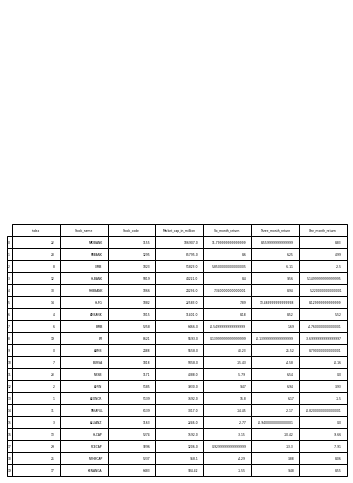

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
 # EDIT: see deprecation warnings below

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

pd.plotting.table(ax, a)  # where df is your data frame

plt.savefig('mytable.png')